# solving the Thomson problem

In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def gen_charges(N, r):
    """each set of charges will have N charges and will be set on a sphere or radius r"""
    charges = []
    
    for charge in range(N):
        
        phi = np.random.uniform(0,2*np.pi)
        costheta = np.random.uniform(-1,1)

        theta = np.arccos( costheta )

        charges.append((r,theta,phi))
        
    
    return charges

def gen_population(size, N, r):
    pop = []
    for _ in range(size):
        pop.append(gen_charges(N,r))
    return pop

def test_charges(charges, r, eps = 0.01):
    """must be of radius r"""
    for charge in charges:
        assert np.abs( (charge[0] * np.sin(charge[1]) * np.cos(charge[2]) )**2 +
                      (charge[0] * np.sin(charge[1]) * np.sin(charge[2]) )**2 +
                      (charge[0] * np.cos(charge[1]))**2
            - r**2) < eps 
        
def compute_U(charges):
    
    def compute_U_partial(pair, k = 1, ei = 1, ej = 1):
        """contribution to U of a single pair is 1/r_ij (actually k* e_i * e_j / r_ij)"""
        
        def dist(pair, eps =0.000001):
            """distance is computed as sqrt( (x_0 - x_1)^2 +...) over all dimensions"""
            
            x0 = pair[0][0] * np.sin( pair[0][1]) * np.cos( pair[0][2] )
            y0 = pair[0][0] * np.sin( pair[0][1]) * np.sin( pair[0][2] )
            z0 = pair[0][0] * np.cos( pair[0][1] )
            x1 = pair[1][0] * np.sin( pair[1][1]) * np.cos( pair[1][2] )
            y1 = pair[1][0] * np.sin( pair[1][1]) * np.sin( pair[1][2] )
            z1 = pair[1][0] * np.cos( pair[1][1] )
            """
            r1 = pair[0][0]
            r2 = pair[1][0]
            theta1 = pair[0][1]
            theta2 = pair[1][1]
            phi1 = pair[0][2]
            phi2 = pair[1][2]
            
            #print(r1,r2,theta1,theta2,phi1,phi2)
            val = r1**2 + r2**2 - \
            2*r1*r2*(np.cos(theta1) * np.cos(theta2) * np.cos(phi1-phi2) + \
                         np.sin(phi1) * np.sin(phi2))
            print(val)
            d = np.sqrt(val)
            """
            d = np.sqrt(  (x0-x1)**2 + (y0-y1)**2 + (z0-z1)**2 )
            if d < eps:
                raise Exception #debug
                #d = eps
                #print(pair)
            return d
        
        return (k* ei* ej)/dist(pair)
    

    U = 0.0
    for pair in it.combinations(charges, 2):
        U -= compute_U_partial(pair)
        
    return U

r = 1
charges = gen_charges(100,r)
test_charges(charges, r)
compute_U(charges)

-5032.705917050488

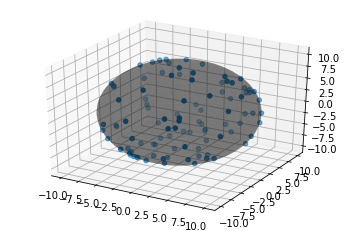

In [8]:
def plot_charges(charges, r = 1):
    x_points = [charge[0]* np.sin( charge[1]) * np.cos( charge[2] )  for charge in charges]
    y_points = [charge[0]* np.sin( charge[1]) * np.sin( charge[2] )  for charge in charges]
    z_points = [charge[0]* np.cos( charge[1])  for charge in charges]
    

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(x_points, y_points, z_points)
    
    N=50
    stride=1
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    x = np.outer(r*np.cos(u), np.sin(v))
    y = np.outer(r*np.sin(u), np.sin(v))
    z = np.outer(r*np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, alpha=0.3, color='k')
    
    plt.show()
    
#test plot
population = gen_population(100,100,10)
#s = sort_pop_by_fitness(population)
plot_charges(population[10],10)

In [30]:
def sort_pop_by_fitness(population, fitness_function = compute_U):
    return sorted(population, key=fitness_function, reverse=True)

def choice(sorted_by_fitness, fitness_sum):
    lowest_fitness = compute_U(sorted_by_fitness[-1])
    #print(list(map(compute_U, sorted_by_fitness)))
    offset = 0
    if lowest_fitness < 0:
        offset = - lowest_fitness
    norm_fitness_sum = fitness_sum + offset*len(sorted_by_fitness)
    
    draw = np.random.uniform(low=0, high=1)
    
    cumulative = 0.0

    for i, charges in enumerate(sorted_by_fitness[::-1]):
        fitness = compute_U(charges) + offset
        probability = (fitness / norm_fitness_sum) ###RIGUARDARE
        cumulative += probability
        #print(probability, cumulative)
        if draw <= cumulative:
            #print("found!", i)
            #print("fitness:", fitness-offset)
            return charges
    else:
        return charges


def crossover(first, second):
    """gets random part of the charges from the first and the other charges from the second
    - forces selecting different indexes otherwise risk of same points
    -TODO for now, it may take nothing from first but at least one from second is always in"""

    charges_size = len(first)
    ratio = np.random.uniform(0,1.01)
    
    first = np.array(first)
    second = np.array(second)
    
    first_idxs = np.random.choice(np.arange(first.shape[0]), replace=False, size = int(ratio*len(first)))
    #second_idxs = [idx for idx in np.arange(second.shape[0]) if not idx in first_idxs]
    newborn = [first[idx] if idx in first_idxs else second[idx] for idx in np.arange(first.shape[0])]
    
    #print(first_contrib, second_contrib)
    return newborn 

def mutate(ind, rate = 0.1):
    """perturbate theta, phi -- REMEMBER: an individual is a SET of charges
    - rate - mutation rate: ratio of charges to be mutated (at least 1)"""
    new_ind = []
    selections = np.random.choice(len(ind), size = max(1, int(rate*len(ind))))

    for selection in np.arange(len(ind)):
        if selection in selections:
            r = ind[selection][0] #not to be modified
            new_theta = ind[selection][1] + np.random.uniform(-0.05/2, 0.05/2)
            new_phi = ind[selection][2] + np.random.uniform(-0.05, 0.05) #phi has half range
            ##keep it inside boundaries
            new_theta = min(max(new_theta, 0), 2*np.pi)
            new_phi = min(max(new_phi, 0), np.pi)
            new_ind.append([r,new_theta,new_phi])

        else:
            
            new_ind.append(ind[selection])

    return new_ind

def make_next_gen(prev_population, ind_size, rate):
    next_gen = []
    sorted_by_fitness = sort_pop_by_fitness(prev_population)
    pop_size = len(prev_population)
    fitness_sum = sum(compute_U(charges) for charges in prev_population)
    
    for i in range(pop_size):
        first_mate = choice(sorted_by_fitness, fitness_sum)
        second_mate = choice(sorted_by_fitness, fitness_sum)
        try:
            individual = crossover(first_mate, second_mate)
            brutal_check(individual)
        except:
            print('crossover causing overlaps')
            break
        try:
            individual = mutate(individual, rate=rate)
            brutal_check(individual)
        except:
            print('mutate causing overlaps')
            break
        #print("-----")
        assert ind_size == len(individual), f'set of charges depleted: {len(individual)}'
        
        next_gen.append(individual)
    return next_gen

def brutal_check(charges):
    compute_U(charges)


In [31]:
def make_ga(pop_size, N_charges, r, generations = 1000, rate=0.1):
    
    #gen population
    population = gen_population(pop_size, N_charges, r)
    #print(population)
    #do generations
    best_u = -99999999
    best_ind = population
    best_gen = -1
    for generation in range(generations):
        ranked = sort_pop_by_fitness(population)
        assert len(ranked) == pop_size, print(len(ranked), pop_size)
        u = compute_U(ranked[0])
            
        if u > best_u:
            best_u = u
            best_ind = ranked[0]
            best_gen = generation
        plot_charges(ranked[0], r=r)
        
        print(f"best set of charges [generation {generation}] : {u}")
        print(f"worst set of charges [generation {generation}] : {compute_U(ranked[-1])}")

        population = make_next_gen(population, N_charges, rate=rate)
        
        
    print(f'best U: {-best_u}')
    print(f'best gen: {best_gen}')
    return best_u, best_ind, best_gen

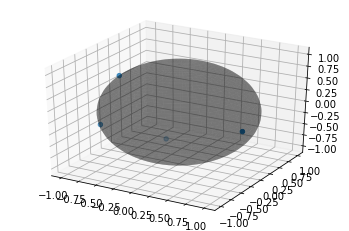

best set of charges [generation 0] : -4.212562148914269
worst set of charges [generation 0] : -9.957597498450491


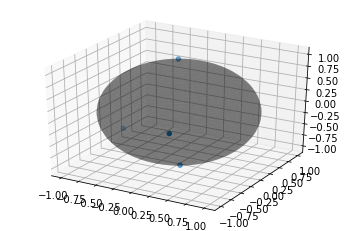

best set of charges [generation 1] : -4.1411903972875965
worst set of charges [generation 1] : -9.446597673952652


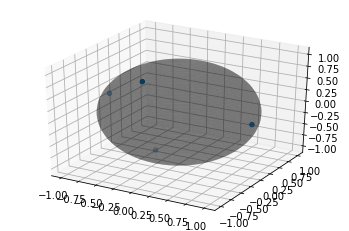

best set of charges [generation 2] : -3.945268750032781
worst set of charges [generation 2] : -9.632314665886863


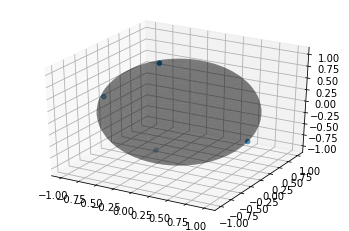

best set of charges [generation 3] : -4.054017001486954
worst set of charges [generation 3] : -6.57068990922836


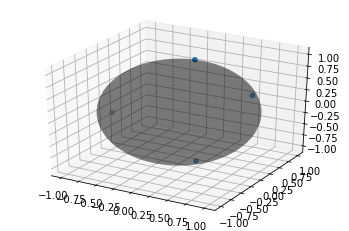

best set of charges [generation 4] : -4.112872476212417
worst set of charges [generation 4] : -19.185645994519216


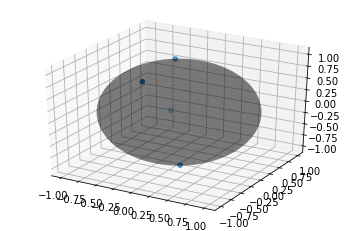

best set of charges [generation 5] : -4.0693220674549195
worst set of charges [generation 5] : -7.477521386492975


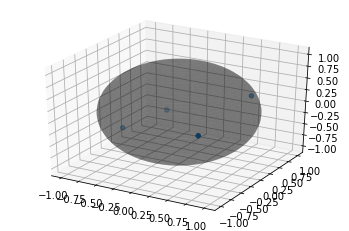

best set of charges [generation 6] : -4.442892156410591
worst set of charges [generation 6] : -6.972870033029033


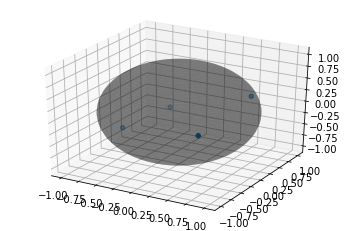

best set of charges [generation 7] : -4.372360088283858
worst set of charges [generation 7] : -27.80128015148246


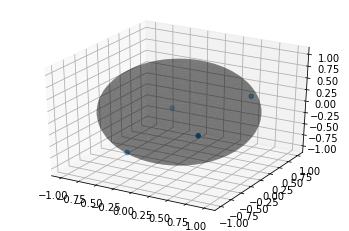

best set of charges [generation 8] : -4.007912726114844
worst set of charges [generation 8] : -8.405848285082206


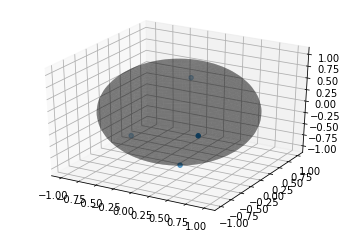

best set of charges [generation 9] : -4.3029699954088665
worst set of charges [generation 9] : -8.294408743945048


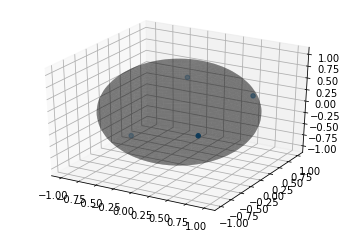

best set of charges [generation 10] : -4.075220940985431
worst set of charges [generation 10] : -7.044452852079395


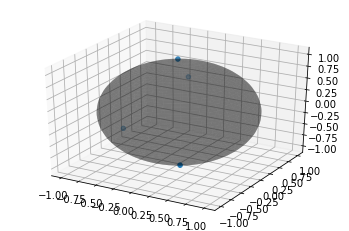

best set of charges [generation 11] : -4.59161558315367
worst set of charges [generation 11] : -8.300712261583229


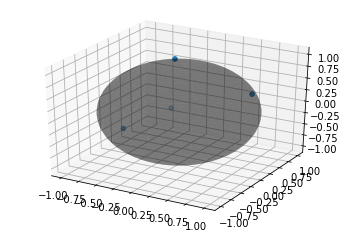

best set of charges [generation 12] : -4.859702728875413
worst set of charges [generation 12] : -6.126084869697859


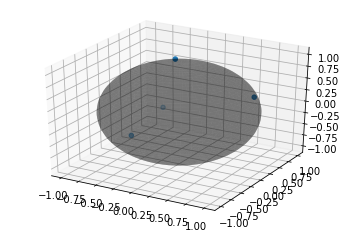

best set of charges [generation 13] : -4.8733805958210095
worst set of charges [generation 13] : -5.39290399100235


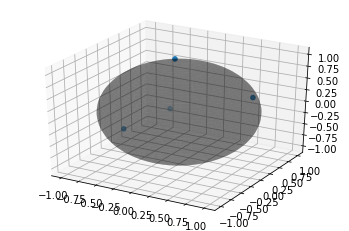

best set of charges [generation 14] : -4.854272055360794
worst set of charges [generation 14] : -5.323724678475575


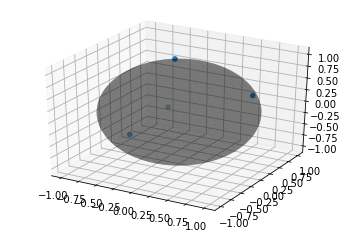

best set of charges [generation 15] : -4.831702925029608
worst set of charges [generation 15] : -5.301697926043568


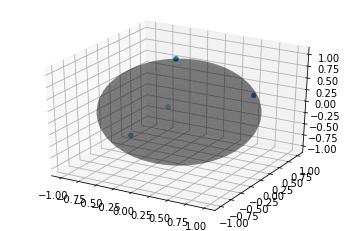

best set of charges [generation 16] : -4.796655336615554
worst set of charges [generation 16] : -5.355813441251465


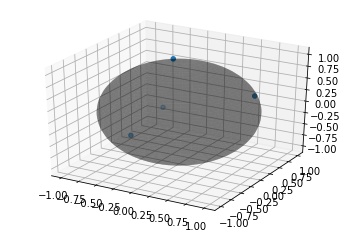

best set of charges [generation 17] : -4.80287608059128
worst set of charges [generation 17] : -5.0767632835053025


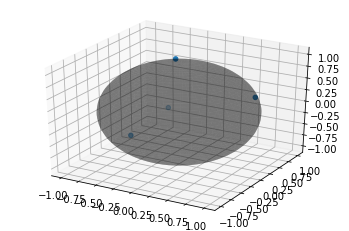

best set of charges [generation 18] : -4.7779786054786175
worst set of charges [generation 18] : -5.014420988357843


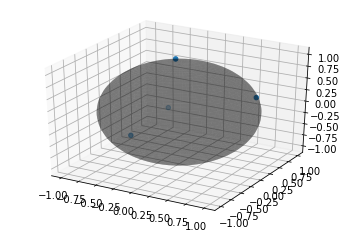

best set of charges [generation 19] : -4.749799043544033
worst set of charges [generation 19] : -4.9979337499303504


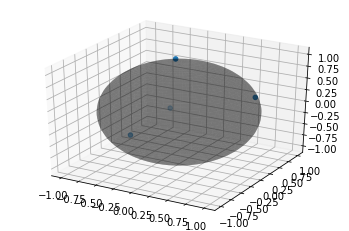

best set of charges [generation 20] : -4.768644195665813
worst set of charges [generation 20] : -4.927812663891466


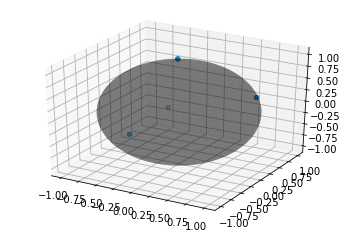

best set of charges [generation 21] : -4.755237674053704
worst set of charges [generation 21] : -4.892113657227423


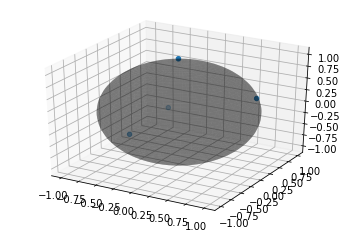

best set of charges [generation 22] : -4.74731660572779
worst set of charges [generation 22] : -4.850495815577543


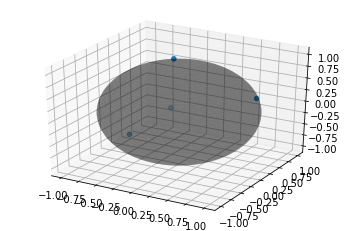

best set of charges [generation 23] : -4.692266699626109
worst set of charges [generation 23] : -4.835210167506801


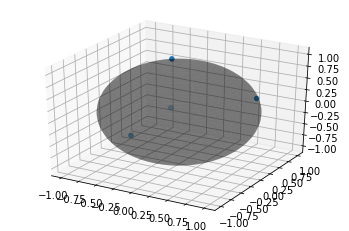

best set of charges [generation 24] : -4.673822478847019
worst set of charges [generation 24] : -4.866093092774403


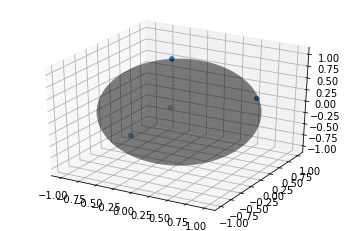

best set of charges [generation 25] : -4.677100172158231
worst set of charges [generation 25] : -4.7900955025506295


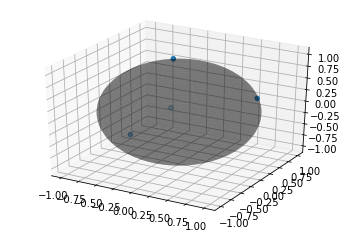

best set of charges [generation 26] : -4.663951660083544
worst set of charges [generation 26] : -4.766073781195652


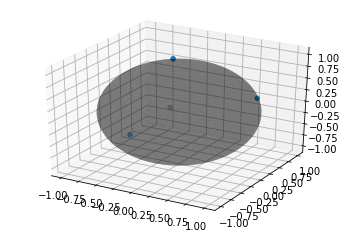

best set of charges [generation 27] : -4.654121235047092
worst set of charges [generation 27] : -4.761778632317003


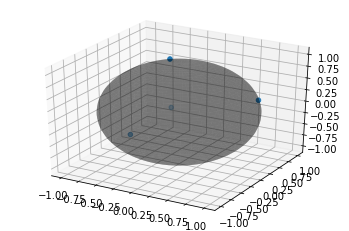

best set of charges [generation 28] : -4.624378352685568
worst set of charges [generation 28] : -4.740828076489811


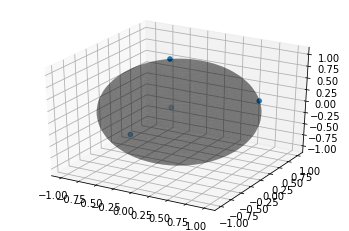

best set of charges [generation 29] : -4.597014545189909
worst set of charges [generation 29] : -4.7395818205422255


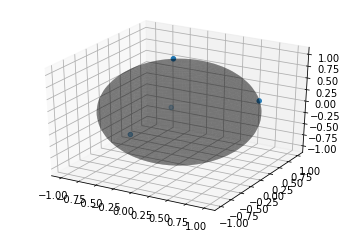

best set of charges [generation 30] : -4.582684645165081
worst set of charges [generation 30] : -4.770022994650816


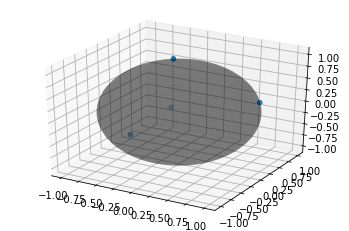

best set of charges [generation 31] : -4.563529867592089
worst set of charges [generation 31] : -4.753327341052065


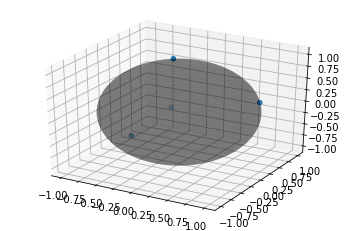

best set of charges [generation 32] : -4.545591935103032
worst set of charges [generation 32] : -4.7237556213537655


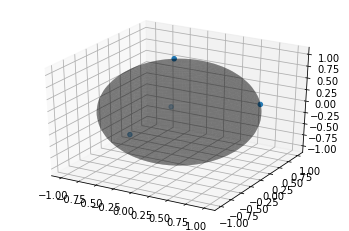

best set of charges [generation 33] : -4.541713728047521
worst set of charges [generation 33] : -4.741387593452987


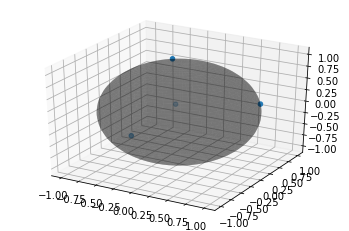

best set of charges [generation 34] : -4.460765238966907
worst set of charges [generation 34] : -4.6828336452912325


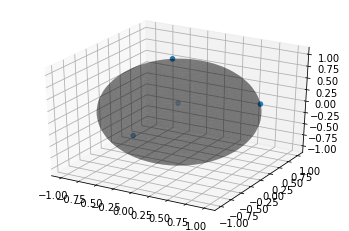

best set of charges [generation 35] : -4.471838124575415
worst set of charges [generation 35] : -4.625111730507664


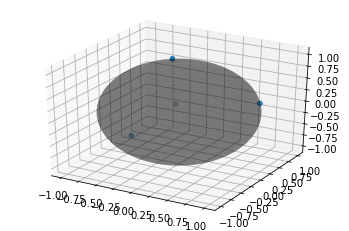

best set of charges [generation 36] : -4.474346264535603
worst set of charges [generation 36] : -4.591455947240453


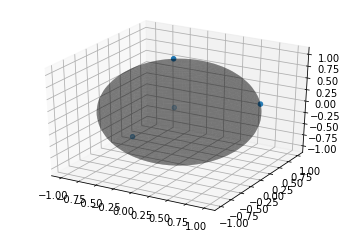

best set of charges [generation 37] : -4.47623779844933
worst set of charges [generation 37] : -4.561241575085366


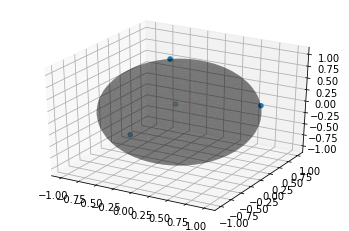

best set of charges [generation 38] : -4.455565340505386
worst set of charges [generation 38] : -4.541776924431443


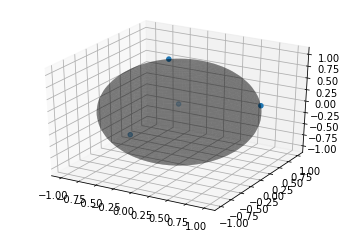

best set of charges [generation 39] : -4.4310323553139135
worst set of charges [generation 39] : -4.519126049831229


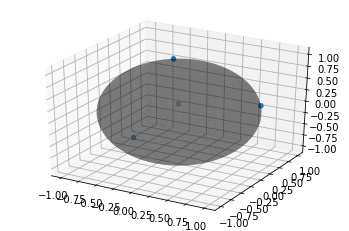

best set of charges [generation 40] : -4.382542460685749
worst set of charges [generation 40] : -4.563350849997796


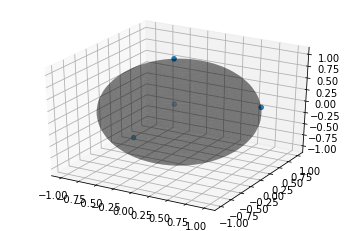

best set of charges [generation 41] : -4.387749423925618
worst set of charges [generation 41] : -4.505606747816618


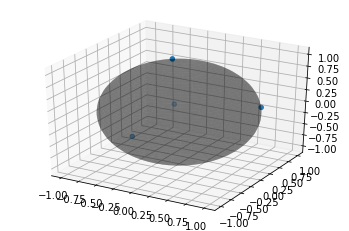

best set of charges [generation 42] : -4.382735244491832
worst set of charges [generation 42] : -4.513407783550059


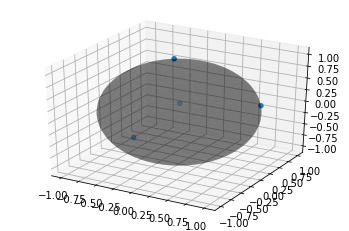

best set of charges [generation 43] : -4.370032188264113
worst set of charges [generation 43] : -4.498340298281967


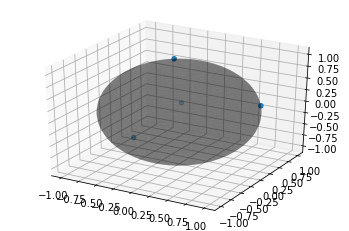

best set of charges [generation 44] : -4.360296958268397
worst set of charges [generation 44] : -4.4740312411799135


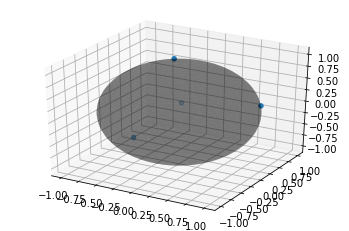

best set of charges [generation 45] : -4.343197769281286
worst set of charges [generation 45] : -4.441229261507756


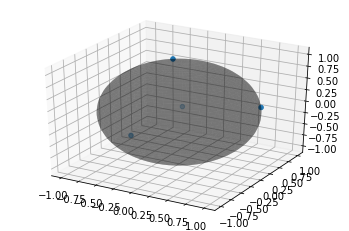

best set of charges [generation 46] : -4.325883023923026
worst set of charges [generation 46] : -4.425105049475253


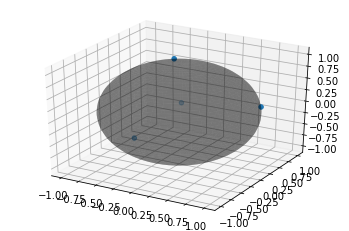

best set of charges [generation 47] : -4.328580024057068
worst set of charges [generation 47] : -4.424176588735472


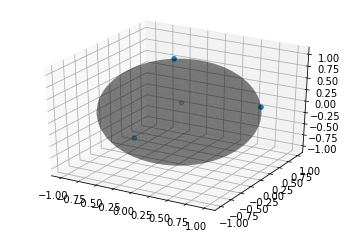

best set of charges [generation 48] : -4.317181740527707
worst set of charges [generation 48] : -4.41854965748584


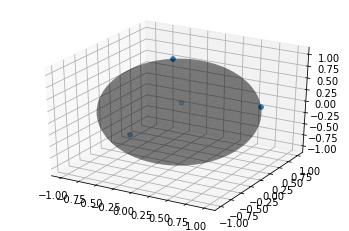

best set of charges [generation 49] : -4.317981579318102
worst set of charges [generation 49] : -4.386278739322043


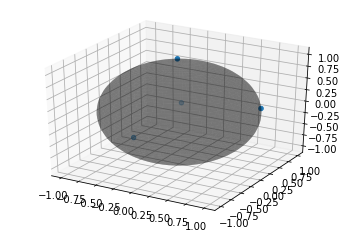

best set of charges [generation 50] : -4.2973398443504935
worst set of charges [generation 50] : -4.360389730361876


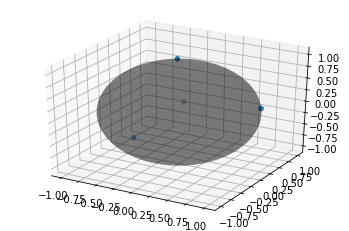

best set of charges [generation 51] : -4.282914435132701
worst set of charges [generation 51] : -4.374564627187494


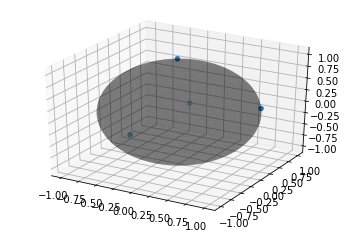

best set of charges [generation 52] : -4.271693633524931
worst set of charges [generation 52] : -4.359469577358593


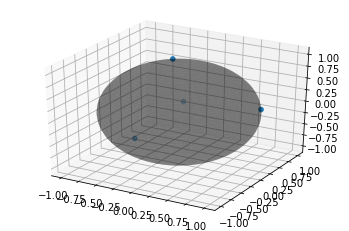

best set of charges [generation 53] : -4.254973507145764
worst set of charges [generation 53] : -4.340251953613778


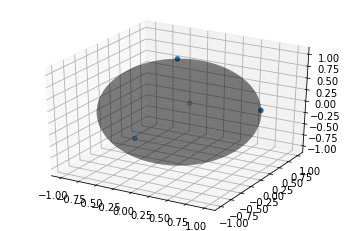

best set of charges [generation 54] : -4.2398672699417315
worst set of charges [generation 54] : -4.364755413678019


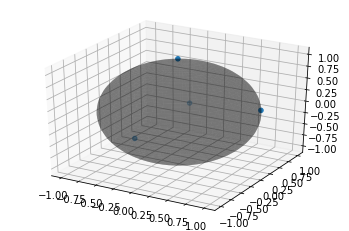

best set of charges [generation 55] : -4.243297404350865
worst set of charges [generation 55] : -4.324617883440475


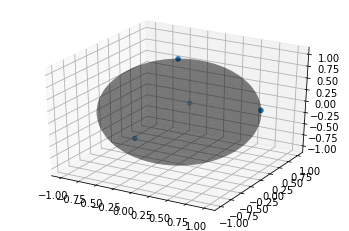

best set of charges [generation 56] : -4.236054763003338
worst set of charges [generation 56] : -4.305272542846394


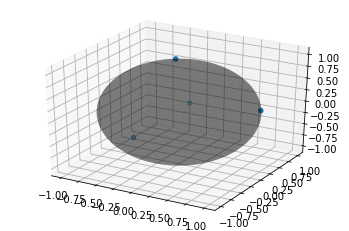

best set of charges [generation 57] : -4.225562265899024
worst set of charges [generation 57] : -4.304858827424686


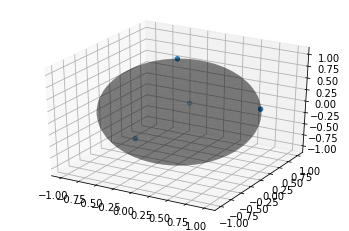

best set of charges [generation 58] : -4.239441064525999
worst set of charges [generation 58] : -4.312854549671932


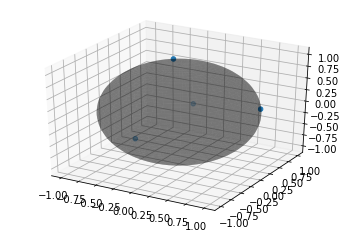

best set of charges [generation 59] : -4.213111820326127
worst set of charges [generation 59] : -4.285518441145359


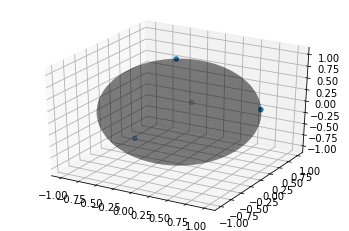

best set of charges [generation 60] : -4.218340039768226
worst set of charges [generation 60] : -4.266712942317184


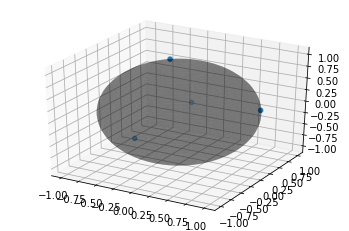

best set of charges [generation 61] : -4.193383978225804
worst set of charges [generation 61] : -4.2774241181526165


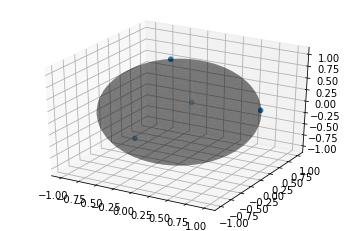

best set of charges [generation 62] : -4.188598769862048
worst set of charges [generation 62] : -4.270913240314464


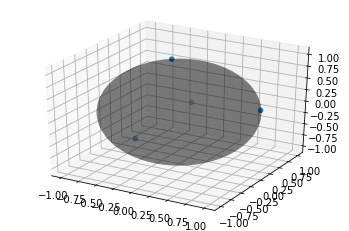

best set of charges [generation 63] : -4.1893650451701
worst set of charges [generation 63] : -4.244605959261279


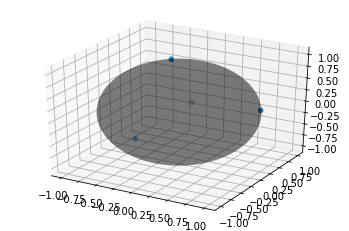

best set of charges [generation 64] : -4.183465291612983
worst set of charges [generation 64] : -4.240838468027716


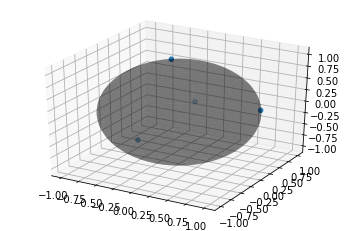

best set of charges [generation 65] : -4.178473636569799
worst set of charges [generation 65] : -4.2381318773685


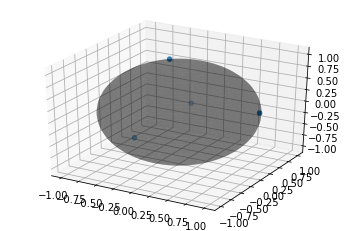

best set of charges [generation 66] : -4.164214727532895
worst set of charges [generation 66] : -4.240869895602918


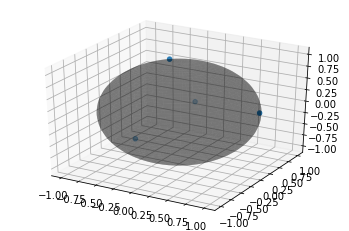

best set of charges [generation 67] : -4.138350834490977
worst set of charges [generation 67] : -4.229911809502528


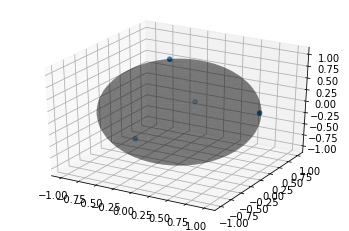

best set of charges [generation 68] : -4.132520767771902
worst set of charges [generation 68] : -4.225832703909911


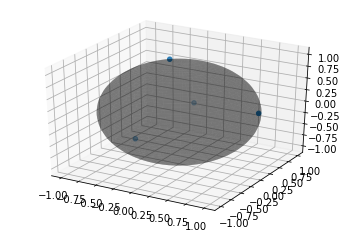

best set of charges [generation 69] : -4.122574200459718
worst set of charges [generation 69] : -4.215496150187775


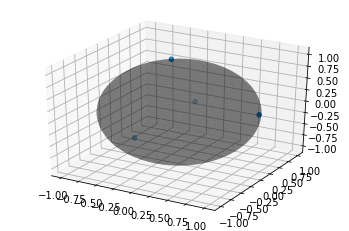

best set of charges [generation 70] : -4.118666683945382
worst set of charges [generation 70] : -4.197240283122095


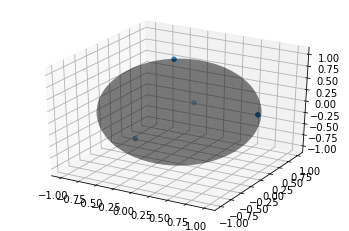

best set of charges [generation 71] : -4.103605328822164
worst set of charges [generation 71] : -4.202585273039693


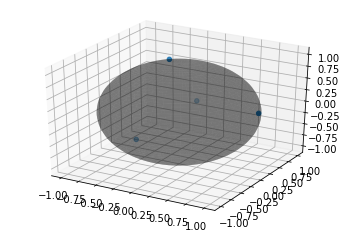

best set of charges [generation 72] : -4.096969015242172
worst set of charges [generation 72] : -4.1758419385706835


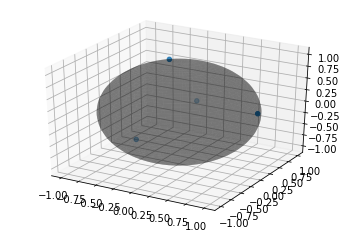

best set of charges [generation 73] : -4.082155122615206
worst set of charges [generation 73] : -4.17211280662142


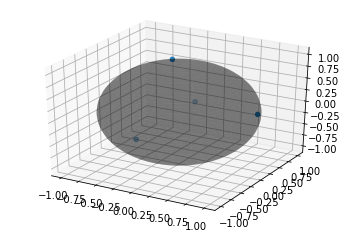

best set of charges [generation 74] : -4.0889106792249
worst set of charges [generation 74] : -4.1555677132009805


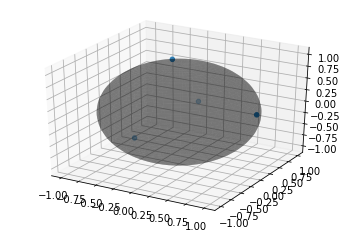

best set of charges [generation 75] : -4.070373318951023
worst set of charges [generation 75] : -4.137214730528717


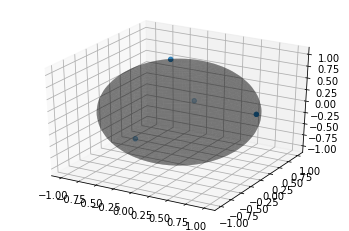

best set of charges [generation 76] : -4.075514970893308
worst set of charges [generation 76] : -4.1459051428521825


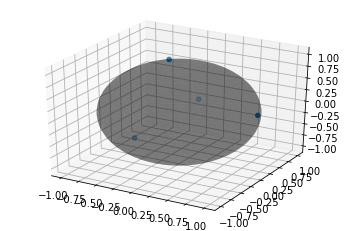

best set of charges [generation 77] : -4.069882700435663
worst set of charges [generation 77] : -4.117486505452432


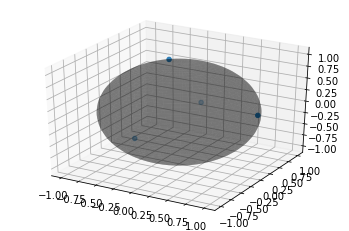

best set of charges [generation 78] : -4.064111549929239
worst set of charges [generation 78] : -4.131391433912904


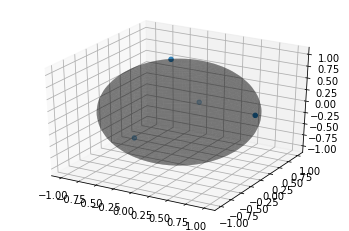

best set of charges [generation 79] : -4.049447799633386
worst set of charges [generation 79] : -4.110234861479141


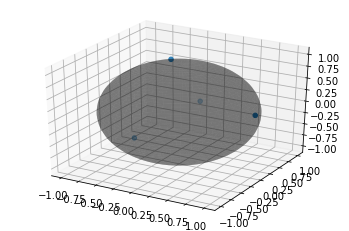

best set of charges [generation 80] : -4.044527966805398
worst set of charges [generation 80] : -4.089456358835371


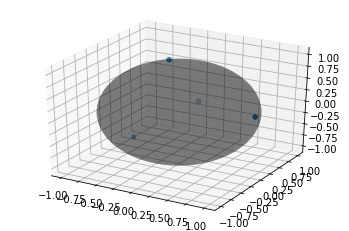

best set of charges [generation 81] : -4.035877891742096
worst set of charges [generation 81] : -4.099589435748634


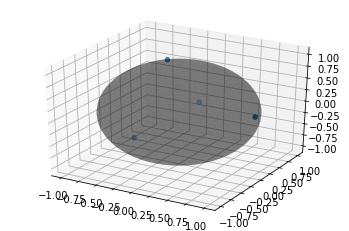

best set of charges [generation 82] : -4.026204014349117
worst set of charges [generation 82] : -4.090100999025559


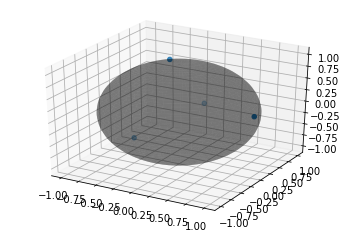

best set of charges [generation 83] : -4.016295382779353
worst set of charges [generation 83] : -4.073617520954935


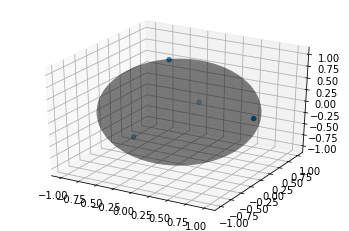

best set of charges [generation 84] : -4.0188014045575615
worst set of charges [generation 84] : -4.070116391578064


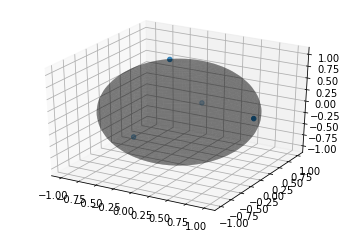

best set of charges [generation 85] : -4.019527154236757
worst set of charges [generation 85] : -4.06836519563628


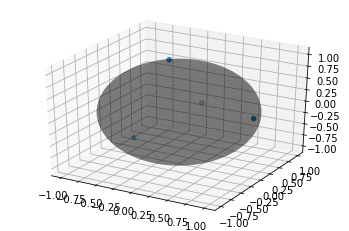

best set of charges [generation 86] : -4.001868416273231
worst set of charges [generation 86] : -4.074121375075203


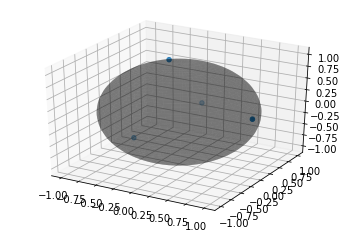

best set of charges [generation 87] : -3.9912388139417656
worst set of charges [generation 87] : -4.084352353619373


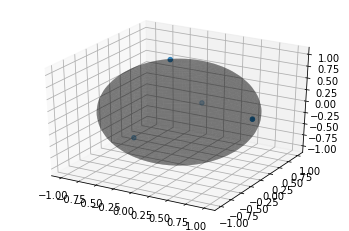

best set of charges [generation 88] : -3.9943880588146863
worst set of charges [generation 88] : -4.0874770288391185


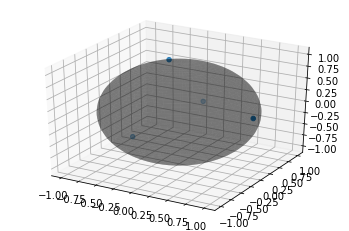

best set of charges [generation 89] : -3.9936123858729675
worst set of charges [generation 89] : -4.044858055780225


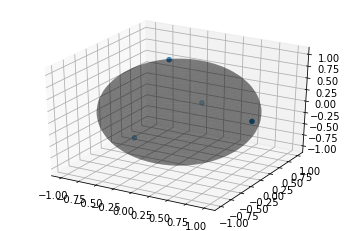

best set of charges [generation 90] : -3.9868082781200656
worst set of charges [generation 90] : -4.041832261409725


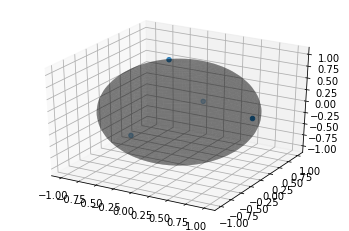

best set of charges [generation 91] : -3.987600566479888
worst set of charges [generation 91] : -4.032418284970385


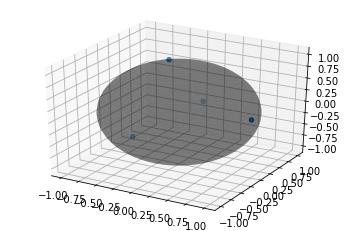

best set of charges [generation 92] : -3.9770759040110035
worst set of charges [generation 92] : -4.011121125292618


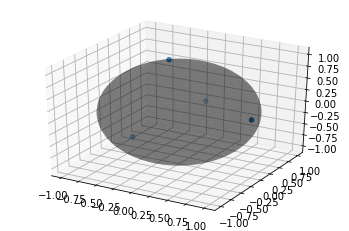

best set of charges [generation 93] : -3.968768259201598
worst set of charges [generation 93] : -4.01008438910903


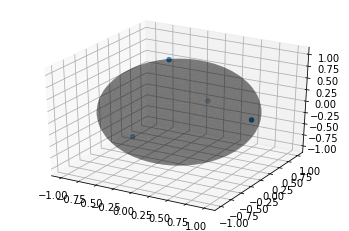

best set of charges [generation 94] : -3.9624926389898265
worst set of charges [generation 94] : -4.014074539587626


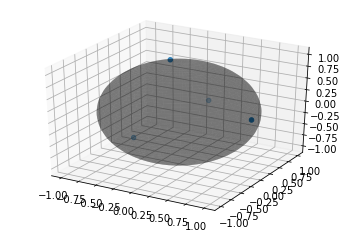

best set of charges [generation 95] : -3.95795184342361
worst set of charges [generation 95] : -3.9974034702355747


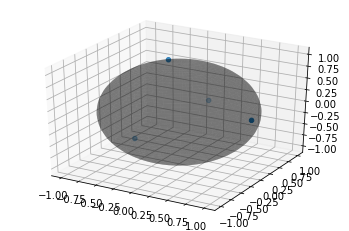

best set of charges [generation 96] : -3.9558995086598667
worst set of charges [generation 96] : -3.9931208359930275


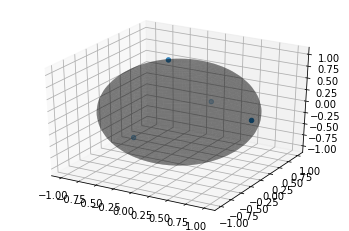

best set of charges [generation 97] : -3.9450822705124846
worst set of charges [generation 97] : -3.996744555767888


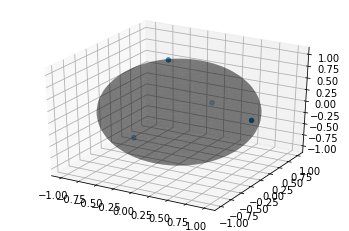

best set of charges [generation 98] : -3.944487644564737
worst set of charges [generation 98] : -3.996845777836752


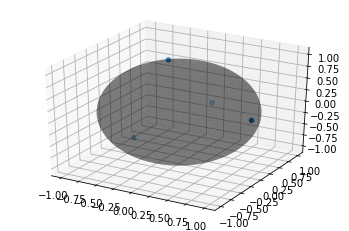

best set of charges [generation 99] : -3.9446384517844173
worst set of charges [generation 99] : -3.985280605007867
best U: -3.944487644564737
best gen: 98


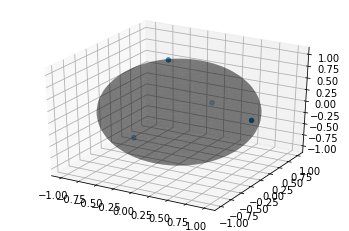

In [32]:
u,ind, gen = make_ga(pop_size=20, N_charges=4, r=1, generations=100, rate= 0.1)
plot_charges(ind, r = 1)
test_charges(ind, r = 1)

In [11]:
##other tests
a = gen_charges(2, 1)
b = gen_charges(2, 1)
print(a)
print(b)
crossover(a,b)

[(1, 2.6260961965488376, 5.244711157517544), (1, 0.723813577873477, 4.503432637659178)]
[(1, 1.351470023996066, 4.856495823021543), (1, 0.8222819281168984, 1.7088450862840174)]


[array([1.        , 2.6260962 , 5.24471116]),
 array([1.        , 0.82228193, 1.70884509])]